## SRJ - Measurement counts

In [1]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import time
import re
from scipy.optimize import minimize
ash_excitation = []
energies = []
excitations= []

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity



bond_length = 3.0
symbols = ["H","H","H","H"]
electrons = 4
orbitals = 8
r_bohr = bond_length *1.8897259886  
coordinates = np.array([[0.0,0.0, 1*r_bohr], [0.0, 0.0, 2*r_bohr], [0.0,0.0,3*r_bohr],[0.0, 0.0, 4*r_bohr]])
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-6g", method="pyscf")
hf_state = qchem.hf_state(electrons, qubits)




def adaptvqe(adapt_it = 4, e_th=1e-12):
    ash_excitation = []
    energies = []
    excitations= []
    #Calculation of HF state
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def circuit(hf_state, electrons, qubits, H):
        print('Updated hf_state is', hf_state)  
        qml.BasisState(hf_state, wires=range(qubits))
        return qml.expval(H)   #Calculating the expectation value of the Hamiltonian
    
    # Commutator calculation for HF state
    @qml.qnode(dev)
    def commutator_0(H,w, k):  #H is the Hamiltonian, w is the operator, k is the basis state - HF state
        qml.BasisState(k, wires=range(qubits))
        res = qml.commutator(H, w)   #Calculating the commutator
        return qml.expval(res)
    
    # Commutator calculation for other states except HF state
    @qml.qnode(dev)
    def commutator_1(H,w, k): #H is the Hamiltonian, w is the operator, k is the basis state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w) #Calculating the commutator
        return qml.expval(res)

    #Energy calculation 
    @qml.qnode(dev)
    def ash(params, ash_excitation, hf_state, H):
        [qml.PauliX(i) for i in np.nonzero(hf_state)[0]]  #Appln of HF state
        for i, excitation in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.expval(H)  #Calculating the expectation value of the Hamiltonian
    
    # Calculation of New state, same as the above function but with the state return
    dev1 = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev1)
    def new_state(hf_state, ash_excitation, params):
        [qml.PauliX(i) for i in np.nonzero(hf_state)[0]] #Applying the HF state
        for i, excitations in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.state()
    
    def cost(params):
        energy = ash(params, ash_excitation, hf_state, H)
        return energy

    def callback(params):
        print(f"Current parameters: {params}")
        print(f"Current cost: {cost(params)}\n")
    

    print('HF state is', circuit(hf_state, electrons, qubits, H))
    singles, doubles = qml.qchem.excitations(electrons, orbitals)
    op1 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "-"}) for x in singles]
    op2 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "+", (2, x[2]): "-", (3, x[3]): "-"})for x in doubles]
    operator_pool = (op1) + (op2)  #Operator pool - Singles and Doubles
    states = [hf_state]
    

    for j in range(adapt_it):
        print('The adapt iteration now is', j)  #Adapt iteration
        max_value = float('-inf')
        max_operator = None
        k = states[-1] if states else hf_state  # if states is empty, fall back to hf_state
       
        for i in operator_pool:
            w = qml.fermi.jordan_wigner(i)  #JW transformation
            if np.array_equal(k, hf_state): # If the current state is the HF state
                current_value = abs(2*(commutator_0(H, w, k)))      #Commutator calculation is activated  
            else:
                current_value = abs(2*(commutator_1(H, w, k)))      #For other states, commutator calculation is activated
            #print(f'The expectation value of {i} is', current_value)

            if current_value > max_value:
                max_value = current_value
                max_operator = i

        #print(f"The highest operator value is {max_value} for operator {max_operator}")  #Highest operator value

        # Convert operator to excitations and append to ash_excitation
        indices_str = re.findall(r'\d+', str(max_operator))
        excitations = [int(index) for index in indices_str]
        print('Highest gradient excitation is', excitations)
        ash_excitation.append(excitations) #Appending the excitations to the ash_excitation
        if j == 0:
            params = qml.numpy.zeros(len(ash_excitation), requires_grad=True)  #Parameters initialization
            #print('Parameters are', params)
        else:
            params = np.append(params, 0.0) 
            #print('Parameters before optimization are', params)


        #Energy calculation
        result = minimize(cost, params, method='powell', callback=callback, tol = e_th, options = {'disp': True, 'maxiter': 1e8, 'xtol':1e-8, 'ftol':1e-8})

        #print("Final updated parameters:", result.x)
        #print("Final cost:", result.fun)

        params= (result.x)
        energies.append(result.fun)
        print('Updated params are', params)
        print('Updated excitation are', ash_excitation)

        # New state generation - With the updated parameters
        ostate = new_state(hf_state, ash_excitation, params)
        print(qml.draw(new_state, max_length=100)(hf_state,ash_excitation,params))
        gs_state = ostate
        # Append the new state to the states list
        states.append(ostate)

    return energies, params, ash_excitation, gs_state, H, qubits, states


In [2]:
energies, params, ash_excitation, gs_state,H, qubits, states = adaptvqe(adapt_it = 10, e_th=1e-12)
print('Energies:', energies)

Updated hf_state is [1 1 1 1 0 0 0 0]
HF state is -1.3325688880668924
The adapt iteration now is 0


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

Highest gradient excitation is [2, 3, 6, 7]
Current parameters: [-1.12299269]
Current cost: -1.430083670840338

Current parameters: [-1.12299269]
Current cost: -1.4300836708403395

Optimization terminated successfully.
         Current function value: -1.430084
         Iterations: 2
         Function evaluations: 37
Updated params are [-1.12299269]
Updated excitation are [[2, 3, 6, 7]]
0: ──X───────────────────────────────────┤  State
1: ──X───────────────────────────────────┤  State
2: ──X─╭FermionicDoubleExcitation(-1.12)─┤  State
3: ──X─├FermionicDoubleExcitation(-1.12)─┤  State
6: ────├FermionicDoubleExcitation(-1.12)─┤  State
7: ────╰FermionicDoubleExcitation(-1.12)─┤  State
The adapt iteration now is 1


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

Highest gradient excitation is [0, 3, 5, 6]
Current parameters: [-1.12299269 -1.38120328]
Current cost: -1.5693729295296868

Current parameters: [-1.09743878 -1.37779489]
Current cost: -1.5694603735015464

Current parameters: [-1.09716179 -1.37775794]
Current cost: -1.569460383552069

Optimization terminated successfully.
         Current function value: -1.569460
         Iterations: 3
         Function evaluations: 151
Updated params are [-1.09716179 -1.37775794]
Updated excitation are [[2, 3, 6, 7], [0, 3, 5, 6]]
0: ──X───────────────────────────────────╭FermionicDoubleExcitation(-1.38)─┤  State
1: ──X───────────────────────────────────│─────────────────────────────────┤  State
2: ──X─╭FermionicDoubleExcitation(-1.10)─│─────────────────────────────────┤  State
3: ──X─├FermionicDoubleExcitation(-1.10)─├FermionicDoubleExcitation(-1.38)─┤  State
5: ────│─────────────────────────────────├FermionicDoubleExcitation(-1.38)─┤  State
6: ────├FermionicDoubleExcitation(-1.10)─╰FermionicDoubleE

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

Highest gradient excitation is [0, 1, 4, 5]
Current parameters: [-1.0971618  -1.37775794 -1.44489273]
Current cost: -1.7420659491146868

Current parameters: [-1.20165231 -1.38132943 -1.45784153]
Current cost: -1.7436329052224744

Current parameters: [-1.20338927 -1.38266277 -1.45805678]
Current cost: -1.74363344089607

Current parameters: [-1.20339191 -1.38268514 -1.45805711]
Current cost: -1.74363344095307

Optimization terminated successfully.
         Current function value: -1.743633
         Iterations: 4
         Function evaluations: 326
Updated params are [-1.20339191 -1.38268514 -1.45805711]
Updated excitation are [[2, 3, 6, 7], [0, 3, 5, 6], [0, 1, 4, 5]]
0: ──X───────────────────────────────────╭FermionicDoubleExcitation(-1.38)
1: ──X───────────────────────────────────│────────────────────────────────
2: ──X─╭FermionicDoubleExcitation(-1.20)─│────────────────────────────────
3: ──X─├FermionicDoubleExcitation(-1.20)─├FermionicDoubleExcitation(-1.38)
4: ────│──────────────────

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

Highest gradient excitation is [1, 2, 4, 7]
Current parameters: [-1.20338117 -1.38268375 -1.45818954 -0.74668209]
Current cost: -1.7950381404324824

Current parameters: [-0.87369622 -1.35355269 -1.12304566 -1.10542579]
Current cost: -1.839649535890136

Current parameters: [-0.8217413  -1.297397   -1.0266048  -1.16075107]
Current cost: -1.8420600740034083

Current parameters: [-0.82588378 -1.28904146 -1.01005239 -1.16435727]
Current cost: -1.8421083776261264

Current parameters: [-0.82832066 -1.28819019 -1.00813387 -1.16401018]
Current cost: -1.8421101065615548

Current parameters: [-0.82877621 -1.28812859 -1.00804507 -1.16386043]
Current cost: -1.8421101508862199

Current parameters: [-0.82882162 -1.28813028 -1.00807023 -1.1638455 ]
Current cost: -1.8421101514224085

Optimization terminated successfully.
         Current function value: -1.842110
         Iterations: 7
         Function evaluations: 608
Updated params are [-0.82882162 -1.28813028 -1.00807023 -1.1638455 ]
Updated excita

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

Highest gradient excitation is [1, 5]
Current parameters: [-0.8288199  -1.28813206 -1.00807113 -1.16383507  0.28091908]
Current cost: -1.850426608029336

Current parameters: [-0.83224734 -1.28907896 -1.01501103 -1.16482944  0.28091908]
Current cost: -1.8504351594976336

Current parameters: [-0.83036895 -1.28925138 -1.01550141 -1.16540842  0.28091908]
Current cost: -1.850435918875086

Current parameters: [-0.83013807 -1.28924723 -1.01541774 -1.16552615  0.28091908]
Current cost: -1.8504359311256544

Optimization terminated successfully.
         Current function value: -1.850436
         Iterations: 4
         Function evaluations: 493
Updated params are [-0.83013807 -1.28924723 -1.01541774 -1.16552615  0.28091908]
Updated excitation are [[2, 3, 6, 7], [0, 3, 5, 6], [0, 1, 4, 5], [1, 2, 4, 7], [1, 5]]
0: ──X───────────────────────────────────╭FermionicDoubleExcitation(-1.29)
1: ──X───────────────────────────────────│────────────────────────────────
2: ──X─╭FermionicDoubleExcitation(-0.8

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

Highest gradient excitation is [2, 6]
Current parameters: [-0.83013539 -1.2892372  -1.01540547 -1.16553127  0.28114007  0.29012238]
Current cost: -1.8594391575550964

Current parameters: [-0.83441897 -1.29150397 -1.0155659  -1.16517445  0.29355165  0.29070632]
Current cost: -1.859460010469704

Current parameters: [-0.83465495 -1.29159278 -1.0156989  -1.16515413  0.29357615  0.29071041]
Current cost: -1.859460024908497

Optimization terminated successfully.
         Current function value: -1.859460
         Iterations: 3
         Function evaluations: 414
Updated params are [-0.83465495 -1.29159278 -1.0156989  -1.16515413  0.29357615  0.29071041]
Updated excitation are [[2, 3, 6, 7], [0, 3, 5, 6], [0, 1, 4, 5], [1, 2, 4, 7], [1, 5], [2, 6]]
0: ──X───────────────────────────────────╭FermionicDoubleExcitation(-1.29)
1: ──X───────────────────────────────────│────────────────────────────────
2: ──X─╭FermionicDoubleExcitation(-0.83)─│────────────────────────────────
3: ──X─├FermionicDoubleE

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

Highest gradient excitation is [3, 7]
Current parameters: [-0.83463482 -1.29159994 -1.01571303 -1.16515764  0.29357665  0.29071037
 -0.01721792]
Current cost: -1.8594919675703112

Current parameters: [-0.83444512 -1.29137717 -1.01573262 -1.16496772  0.29347023  0.3082999
 -0.035198  ]
Current cost: -1.8595601670708688

Current parameters: [-0.79789281 -1.31434913 -1.00144063 -1.19101187  0.32060453  1.52318488
 -1.24023186]
Current cost: -1.8655683930669527

Current parameters: [-0.80977843 -1.32801464 -0.9867061  -1.20059477  0.31927005  1.54713811
 -1.26475619]
Current cost: -1.865655897966464

Current parameters: [-0.81701798 -1.3331985  -0.98109403 -1.20391541  0.31938435  1.55753888
 -1.27546441]
Current cost: -1.865673513978507

Current parameters: [-0.82176306 -1.33664722 -0.97761997 -1.20616259  0.31947364  1.56457675
 -1.28274012]
Current cost: -1.8656767409569068

Optimization terminated successfully.
         Current function value: -1.865677
         Iterations: 6
         

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

Highest gradient excitation is [2, 3, 6, 7]
Current parameters: [-0.82174365 -1.33665703 -0.9776178  -1.20616503  0.31947258  1.56457845
 -1.28274534  0.07819433]
Current cost: -1.8663329831365998

Current parameters: [-0.83161332 -1.3443036  -0.9706553  -1.2119147   0.31899387  1.56468303
 -1.28619968  0.08110544]
Current cost: -1.8663660827736357

Current parameters: [-0.83533184 -1.3465691  -0.96749536 -1.21316267  0.31905163  1.56797472
 -1.28943787  0.08219464]
Current cost: -1.8663726618650482

Current parameters: [-0.83675434 -1.34724955 -0.96653478 -1.2135055   0.31904117  1.57106782
 -1.29243681  0.08261616]
Current cost: -1.8663752276632433

Current parameters: [-0.84044825 -1.34916288 -0.96386454 -1.21454586  0.31902503  1.58528019
 -1.30618266  0.08385377]
Current cost: -1.866381308133966

Current parameters: [-0.83984141 -1.34898605 -0.96412525 -1.21451024  0.31903359  1.58918966
 -1.30995756  0.08381007]
Current cost: -1.8663832065701955

Current parameters: [-0.83652506 

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

Highest gradient excitation is [0, 4]
Current parameters: [-0.83653392 -1.3479982  -0.96560109 -1.21429845  0.31907503  1.61054628
 -1.33057115  0.08360709 -0.06804967]
Current cost: -1.8668832865913532

Current parameters: [-0.83896647 -1.34530747 -0.96635768 -1.21120604  0.38882206  1.6106186
 -1.33092027  0.08314557 -0.13936652]
Current cost: -1.8679574247178539

Current parameters: [-0.83734546 -1.26933755 -0.98720543 -1.14265315  1.62864264  1.62404059
 -1.34731074  0.06620492 -1.3415338 ]
Current cost: -1.8837111924175887

Current parameters: [-0.82784799 -1.25841196 -0.98457175 -1.13498364  1.62913318  1.633634
 -1.3557468   0.06556997 -1.34213928]
Current cost: -1.8837677286803731

Current parameters: [-0.80813311 -1.22722389 -0.97094099 -1.11022576  1.62944765  1.65849565
 -1.3787641   0.06561361 -1.34349741]
Current cost: -1.8838374271902265

Current parameters: [-0.80538574 -1.2131374  -0.96309698 -1.09841411  1.6247181   1.66586353
 -1.38574021  0.06622992 -1.33885982]
Curr

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

Highest gradient excitation is [0, 1, 4, 5]
Current parameters: [-0.56550444 -0.6461793  -0.59167891 -0.61966125  1.63560823  1.70591705
 -1.42394288  0.07426405 -1.35001602  0.00340386]
Current cost: -1.8843573016114914

Current parameters: [-0.56556756 -0.64617308 -0.59199532 -0.6198305   1.63683175  1.7057783
 -1.42385952  0.07435381 -1.3520863   0.00504935]
Current cost: -1.8843584227350547

Current parameters: [-0.56613584 -0.64729208 -0.595177   -0.62156286  1.65441182  1.70506611
 -1.42364409  0.07480195 -1.37299417  0.02392345]
Current cost: -1.8843683098194095

Current parameters: [-0.56756064 -0.65177135 -0.59889785 -0.6243226   1.68130441  1.70560723
 -1.42391882  0.07508542 -1.40253975  0.0511659 ]
Current cost: -1.8843769403257333

Current parameters: [-0.56911253 -0.652905   -0.59957133 -0.62561018  1.68803746  1.70596433
 -1.42407417  0.07518403 -1.40822008  0.05703081]
Current cost: -1.88438044897946

Current parameters: [-0.57398662 -0.65793283 -0.60342426 -0.63083364 

In [3]:
import pennylane as qml

# Initialize device with 1000 shots
dev4 = qml.device("lightning.qubit", wires=qubits, shots=10000)

@qml.qnode(dev4)
def measurement(gs_state):
    qml.StatePrep(gs_state, wires=range(qubits))
    return qml.counts()  # Samples all qubits

counts = measurement(gs_state)
print(counts)
#Highest probability state : |11110000>
#1 Adapt : HF state
#2 Adapt : |11110000> state
#3 Adapt : |01100110>
#4 Adapt : |11110000> - 2808
#5 Adapt : |11110000> - 2781
#7 Adapt : |11110000> - 1949

# 10 Adapt - lowest count : |00101101> - 21 counts

{'00001111': 1477, '00011110': 38, '00101101': 21, '00111100': 1780, '01001011': 40, '01011010': 46, '01100110': 1259, '01101001': 72, '01111000': 27, '10000111': 35, '10010110': 70, '10011001': 1222, '10100101': 43, '10110100': 45, '11000011': 1746, '11010010': 60, '11100001': 29, '11110000': 1990}


In [4]:
import numpy as np
cstate = np.array([0, 0, 1, 0, 1, 1, 0, 1])

## Adding lowest count instead of HF state

In [5]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import time
import re
from scipy.optimize import minimize
ash_excitation = []
energies = []
excitations= []
grad = []

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity



bond_length = 3.0
symbols = ["H","H","H","H"]
electrons = 4
orbitals = 8
r_bohr = bond_length *1.8897259886  
coordinates = np.array([[0.0,0.0, 1*r_bohr], [0.0, 0.0, 2*r_bohr], [0.0,0.0,3*r_bohr],[0.0, 0.0, 4*r_bohr]])
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-6g", method="pyscf")
hf_state = qchem.hf_state(electrons, qubits)




def adaptvqe(cstate,adapt_it = 4, e_th=1e-12):
    ash_excitation = []
    energies = []
    excitations= []
    #Calculation of HF state
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def circuit(hf_state, electrons, qubits, H):
        print('Updated hf_state is', hf_state)  
        qml.BasisState(hf_state, wires=range(qubits))
        return qml.expval(H)   #Calculating the expectation value of the Hamiltonian
    
    # Commutator calculation for HF state
    @qml.qnode(dev)
    def commutator_0(H,w, k):  #H is the Hamiltonian, w is the operator, k is the basis state - HF state
        qml.BasisState(k, wires=range(qubits))
        res = qml.commutator(H, w)   #Calculating the commutator
        return qml.expval(res)
    
    # Commutator calculation for other states except HF state
    @qml.qnode(dev)
    def commutator_1(H,w, k): #H is the Hamiltonian, w is the operator, k is the basis state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w) #Calculating the commutator
        return qml.expval(res)

    #Energy calculation 
    @qml.qnode(dev)
    def ash(params, ash_excitation, cstate, H):
        #[qml.PauliX(i) for i in np.nonzero(hf_state)[0]]  #Appln of HF state
        qml.BasisState(cstate, wires=range(qubits))  #Applying the c state
        for i, excitation in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.expval(H)  #Calculating the expectation value of the Hamiltonian
    
    # Calculation of New state, same as the above function but with the state return
    dev1 = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev1)
    def new_state(cstate, ash_excitation, params):
        #[qml.PauliX(i) for i in np.nonzero(hf_state)[0]] #Applying the HF state
        qml.BasisState(cstate, wires=range(qubits))  #Applying the c state
        for i, excitations in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.state()
    
    def cost(params):
        energy = ash(params, ash_excitation, hf_state, H)
        return energy

    def callback(params):
        print(f"Current parameters: {params}")
        print(f"Current cost: {cost(params)}\n")
    

    print('HF state is', circuit(hf_state, electrons, qubits, H))
    singles, doubles = qml.qchem.excitations(electrons, orbitals)
    op1 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "-"}) for x in singles]
    op2 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "+", (2, x[2]): "-", (3, x[3]): "-"})for x in doubles]
    operator_pool = (op1) + (op2)  #Operator pool - Singles and Doubles
    states = [cstate]
    

    for j in range(adapt_it):
        print('The adapt iteration now is', j)  #Adapt iteration
        max_value = float('-inf')
        max_operator = None
        k = states[-1] if states else cstate  # if states is empty, fall back to hf_state
       
        for i in operator_pool:
            w = qml.fermi.jordan_wigner(i)  #JW transformation
            if np.array_equal(k, cstate): # If the current state is the HF state
                print('Current state is c state')
                current_value = abs(2*(commutator_0(H, w, k)))      #Commutator calculation is activated  
            else:
                current_value = abs(2*(commutator_1(H, w, k)))      #For other states, commutator calculation is activated
            #print(f'The expectation value of {i} is', current_value)

            if current_value > max_value:
                max_value = current_value
                max_operator = i

        print(f"The highest operator value is {max_value} for operator {max_operator}")  #Highest operator value
        grad.append(max_value)
        # Convert operator to excitations and append to ash_excitation
        indices_str = re.findall(r'\d+', str(max_operator))
        excitations = [int(index) for index in indices_str]
        print('Highest gradient excitation is', excitations)
        ash_excitation.append(excitations) #Appending the excitations to the ash_excitation
        if j == 0:
            params = qml.numpy.zeros(len(ash_excitation), requires_grad=True)  #Parameters initialization

        else:
            params = np.append(params, 0.0) 
 


        #Energy calculation
        result = minimize(cost, params, method='powell', callback=callback, tol = e_th, options = {'disp': True, 'maxiter': 1e8, 'xtol':1e-8, 'ftol':1e-8})

        #print("Final updated parameters:", result.x)
        #print("Final cost:", result.fun)

        params= (result.x)
        energies.append(result.fun)
        print('Updated params are', params)
        print('Updated excitation are', ash_excitation)

        # New state generation - With the updated parameters
        ostate = new_state(hf_state, ash_excitation, params)
        print(qml.draw(new_state, max_length=100)(hf_state,ash_excitation,params))
        gs_state = ostate
        # Append the new state to the states list
        states.append(ostate)

    return energies, params, ash_excitation, gs_state, H, qubits


In [6]:
energies, params, ash_excitation, gs_state,H, qubits = adaptvqe(cstate, adapt_it = 10, e_th=1e-12)
print('Energies:', energies)

Updated hf_state is [1 1 1 1 0 0 0 0]
HF state is -1.3325688880668922
The adapt iteration now is 0
Current state is c state
Current state is c state
Current state is c state
Current state is c state
Current state is c state
Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

Current state is c state
Current state is c state
Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state
Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state
Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state
Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state
Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state
The highest operator value is 0.30781905251204217 for operator a⁺(0) a⁺(3) a(4) a(7)
Highest gradient excitation is [0, 3, 4, 7]
Current parameters: [1.19160488]
Current cost: -1.4369182961426445

Current parameters: [1.19160442]
Current cost: -1.4369182961426663

Optimization terminated successfully.
         Current function value: -1.436918
         Iterations: 2
         Function evaluations: 35
Updated params are [1.19160442]
Updated excitation are [[0, 3, 4, 7]]
0: ─╭|Ψ⟩─╭FermionicDoubleExcitation(1.19)─┤  State
1: ─├|Ψ⟩─│────────────────────────────────┤  State
2: ─├|Ψ⟩─│────────────────────────────────┤  State
3: ─├|Ψ⟩─├FermionicDoubleExcitation(1.19)─┤  State
4: ─├|Ψ⟩─├FermionicDoubleExcitation(1.19)─┤  State
5: ─├|Ψ⟩─│────────────────────────────────┤  State
6: ─├|Ψ⟩─│────────────────────────────────┤  State
7: ─╰|Ψ⟩─╰FermionicDoubleExcitation(1.19)─┤  State
The adapt iteration now is 1


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.3756256033684313 for operator a⁺(2) a⁺(3) a(4) a(5)
Highest gradient excitation is [2, 3, 4, 5]
Current parameters: [ 1.19160446 -1.45016162]
Current cost: -1.5904691992126276

Current parameters: [ 1.10941365 -1.44126794]
Current cost: -1.5913667178894788

Current parameters: [ 1.10880105 -1.44120156]
Current cost: -1.5913667670448528

Optimization terminated successfully.
         Current function value: -1.591367
         Iterations: 3
         Function evaluations: 190
Updated params are [ 1.10880105 -1.44120156]
Updated excitation are [[0, 3, 4, 7], [2, 3, 4, 5]]
0: ─╭|Ψ⟩─╭FermionicDoubleExcitation(1.11)───────────────────────────────────┤  State
1: ─├|Ψ⟩─│──────────────────────────────────────────────────────────────────┤  State
2: ─├|Ψ⟩─│────────────────────────────────╭FermionicDoubleExcitation(-1.44)─┤  State
3: ─├|Ψ⟩─├FermionicDoubleExcitation(1.11)─├FermionicDoubleExcitation(-1.44)─┤  State
4: ─├|Ψ⟩─├FermionicDoubleExcitation(1.11)─├FermionicD

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.4257932943018233 for operator a⁺(1) a⁺(2) a(5) a(6)
Highest gradient excitation is [1, 2, 5, 6]
Current parameters: [ 1.10880105 -1.44120151  1.44969185]
Current cost: -1.7651077446819008

Current parameters: [ 1.19619963 -1.40746816  1.45393504]
Current cost: -1.7663391540941062

Current parameters: [ 1.19175303 -1.40698245  1.45353814]
Current cost: -1.7663420345429175

Current parameters: [ 1.19166168 -1.40694309  1.45352999]
Current cost: -1.7663420357736053

Optimization terminated successfully.
         Current function value: -1.766342
         Iterations: 4
         Function evaluations: 310
Updated params are [ 1.19166168 -1.40694309  1.45352999]
Updated excitation are [[0, 3, 4, 7], [2, 3, 4, 5], [1, 2, 5, 6]]
0: ─╭|Ψ⟩─╭FermionicDoubleExcitation(1.19)──────────────────────────────────
1: ─├|Ψ⟩─│─────────────────────────────────────────────────────────────────
2: ─├|Ψ⟩─│────────────────────────────────╭FermionicDoubleExcitation(-1.41)
3: ─├|Ψ⟩─├

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.267352093968067 for operator a⁺(0) a⁺(1) a(6) a(7)
Highest gradient excitation is [0, 1, 6, 7]
Current parameters: [ 1.19166178 -1.40694309  1.45352771 -0.72488986]
Current cost: -1.815818356110963

Current parameters: [ 0.87121081 -1.37125693  1.13304182 -1.06527101]
Current cost: -1.8572069744341273

Current parameters: [ 0.82504012 -1.3247426   1.04084521 -1.11626104]
Current cost: -1.859214997935859

Current parameters: [ 0.83114667 -1.31911646  1.02453681 -1.11902652]
Current cost: -1.8592599096151512

Current parameters: [ 0.83412942 -1.3187344   1.02259994 -1.11848023]
Current cost: -1.8592621368567606

Current parameters: [ 0.83473925 -1.31871004  1.02251132 -1.11836896]
Current cost: -1.85926220330947

Optimization terminated successfully.
         Current function value: -1.859262
         Iterations: 6
         Function evaluations: 483
Updated params are [ 0.83473925 -1.31871004  1.02251132 -1.11836896]
Updated excitation are [[0, 3, 4, 7], [

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.006295379202668903 for operator a⁺(0) a⁺(1) a(4) a(5)
Highest gradient excitation is [0, 1, 4, 5]
Current parameters: [ 0.83474081 -1.31873985  1.02253277 -1.11826437 -0.02381499]
Current cost: -1.8592997062155936

Current parameters: [ 0.83435206 -1.31700392  1.02162066 -1.11680416 -0.02434455]
Current cost: -1.859300489818644

Current parameters: [ 0.83471948 -1.3169965   1.02184019 -1.11655323 -0.02434191]
Current cost: -1.85930052845665

Current parameters: [ 0.83471616 -1.31700913  1.02190899 -1.11653315 -0.02433718]
Current cost: -1.8593005291079776

Optimization terminated successfully.
         Current function value: -1.859301
         Iterations: 4
         Function evaluations: 498
Updated params are [ 0.83471616 -1.31700913  1.02190899 -1.11653315 -0.02433718]
Updated excitation are [[0, 3, 4, 7], [2, 3, 4, 5], [1, 2, 5, 6], [0, 1, 6, 7], [0, 1, 4, 5]]
0: ─╭|Ψ⟩─╭FermionicDoubleExcitation(0.83)──────────────────────────────────
1: ─├|Ψ⟩─│─────

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.012757803648024528 for operator a⁺(2) a⁺(3) a(6) a(7)
Highest gradient excitation is [2, 3, 6, 7]
Current parameters: [ 0.83470419 -1.31701104  1.02191942 -1.11653475 -0.02433661 -0.04818713]
Current cost: -1.8594542989369764

Current parameters: [ 0.83392554 -1.3129977   1.01992473 -1.1140169  -0.07277401 -0.09685937]
Current cost: -1.8597707482334136

Current parameters: [ 0.85069517 -1.20827577  0.99591043 -1.02553996 -1.05248734 -1.05113402]
Current cost: -1.8650237663356752

Current parameters: [ 0.85534071 -1.20294073  1.00444863 -1.01893587 -1.0649083  -1.06375858]
Current cost: -1.8650491283703263

Current parameters: [ 0.85447232 -1.20277712  1.00726645 -1.01890452 -1.06749387 -1.0669389 ]
Current cost: -1.8650507618663081

Current parameters: [ 0.85353322 -1.20312855  1.00788253 -1.01940148 -1.06704468 -1.06664045]
Current cost: -1.8650509980618857

Current parameters: [ 0.85337631 -1.20312218  1.0078556  -1.01950374 -1.06711034 -1.06672618]
Cu

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.008479484936105643 for operator a⁺(1) a⁺(2) a(4) a(7)
Highest gradient excitation is [1, 2, 4, 7]
Current parameters: [ 0.85335685 -1.20314086  1.00785053 -1.01952349 -1.06710554 -1.06673668
 -0.03232391]
Current cost: -1.8651195473264603

Current parameters: [ 0.85232084 -1.20130318  1.00651416 -1.01829506 -1.06629156 -1.0651529
 -0.0329508 ]
Current cost: -1.8651208566528172

Current parameters: [ 0.85293721 -1.20109099  1.00647213 -1.01791357 -1.06480485 -1.06376083
 -0.03302152]
Current cost: -1.8651212618386528

Current parameters: [ 0.85365062 -1.20081751  1.00649812 -1.01741746 -1.0612798  -1.06045073
 -0.0331933 ]
Current cost: -1.8651217190004288

Current parameters: [ 0.85351635 -1.20086627  1.00648418 -1.01749085 -1.06004599 -1.05928178
 -0.0332608 ]
Current cost: -1.8651219051778043

Current parameters: [ 0.85267277 -1.20123944  1.00628542 -1.01801826 -1.05231401 -1.05195498
 -0.03368437]
Current cost: -1.8651224526199726

Optimization termin

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.017540995769319095 for operator a⁺(0) a⁺(3) a(5) a(6)
Highest gradient excitation is [0, 3, 5, 6]
Current parameters: [ 0.85270364 -1.20124677  1.00625379 -1.01801583 -1.05230456 -1.05194632
 -0.03368507 -0.06676828]
Current cost: -1.86541546724977

Current parameters: [ 0.8501403  -1.19704251  1.00387736 -1.01521128 -1.05060127 -1.04866763
 -0.10059066 -0.13374169]
Current cost: -1.866013472650328

Current parameters: [ 0.78214309 -1.06343357  0.88701953 -0.88642614 -0.93252847 -0.89167864
 -1.31830792 -1.32943582]
Current cost: -1.878158324990685

Current parameters: [ 0.76509186 -1.00033622  0.84213433 -0.84786633 -0.85489366 -0.82993415
 -1.31179424 -1.31719581]
Current cost: -1.880050760151997

Current parameters: [ 0.69870488 -0.91423342  0.76544636 -0.80107814 -0.75983651 -0.75832262
 -1.31954374 -1.31902956]
Current cost: -1.881301677458032

Current parameters: [ 0.69337801 -0.90834404  0.76239844 -0.79904237 -0.7599684  -0.76130635
 -1.32254984 

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.020908818294955233 for operator a⁺(1) a(5)
Highest gradient excitation is [1, 5]
Current parameters: [ 0.68892175 -0.89914608  0.75814282 -0.79308045 -0.76452172 -0.76386385
 -1.32594994 -1.32593302  0.0453123 ]
Current cost: -1.8815558448760032

Current parameters: [ 0.68799309 -0.89532996  0.755743   -0.78802406 -0.76554153 -0.76483781
 -1.32668852 -1.32698232  0.04598145]
Current cost: -1.8815614495623454

Current parameters: [ 0.68424442 -0.88592674  0.7501222  -0.78060144 -0.7671192  -0.76596261
 -1.32935258 -1.32974319  0.04737792]
Current cost: -1.8815678423402198

Current parameters: [ 0.68281126 -0.88407178  0.74916792 -0.78019652 -0.76691871 -0.76577843
 -1.3305183  -1.33079712  0.0476282 ]
Current cost: -1.8815687257332163

Current parameters: [ 0.68130651 -0.88248644  0.74816635 -0.77976093 -0.76656749 -0.76547994
 -1.33233067 -1.33234908  0.04786666]
Current cost: -1.8815690843940451

Current parameters: [ 0.68129487 -0.88249775  0.74809406 

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.039169502644750255 for operator a⁺(2) a(6)
Highest gradient excitation is [2, 6]
Current parameters: [ 0.68141005 -0.88254001  0.74808223 -0.7797128  -0.76653549 -0.76548743
 -1.33289935 -1.33279873  0.04787472  0.08444382]
Current cost: -1.8823966143563806

Current parameters: [ 0.67995155 -0.87631054  0.7443237  -0.77150412 -0.76753447 -0.76782032
 -1.33378926 -1.3347993   0.11904262  0.14419189]
Current cost: -1.8834145952105916

Current parameters: [ 0.66664745 -0.83963857  0.72301362 -0.73783032 -0.77545903 -0.77533977
 -1.34400808 -1.34756791  0.28095451  0.27775678]
Current cost: -1.8845547285312736

Current parameters: [ 0.65757835 -0.82278004  0.71278742 -0.72536247 -0.77674901 -0.77622152
 -1.35150664 -1.35451345  0.28031289  0.27728294]
Current cost: -1.8846425966963078

Current parameters: [ 0.58631984 -0.69911732  0.62805496 -0.62935368 -0.78164533 -0.77980726
 -1.40342784 -1.40129111  0.27946226  0.27703607]
Current cost: -1.884903131716429

In [1]:
import numpy as np

grad = np.array([0.30781905251204217,
 0.3756256033684313,
 0.4257932943018233,
 0.267352093968067,
 0.006295379202668903,
 0.012757803648024528,
 0.008479484936105643,
 0.017540995769319095,
 0.020908818294955233,
 0.039169502644750255])

energies = np.array([-1.436918296142666, -1.5913667670448528, -1.7663420357736055, -1.85926220330947, -1.8593005291079776, -1.8650510053649978, -1.8651224526199728, -1.8813188905720912, -1.8815691029856536, -1.8849205477143336]
)

In [2]:
FCI = np.full(10, -1.88512490)
print(FCI)

[-1.8851249 -1.8851249 -1.8851249 -1.8851249 -1.8851249 -1.8851249
 -1.8851249 -1.8851249 -1.8851249 -1.8851249]


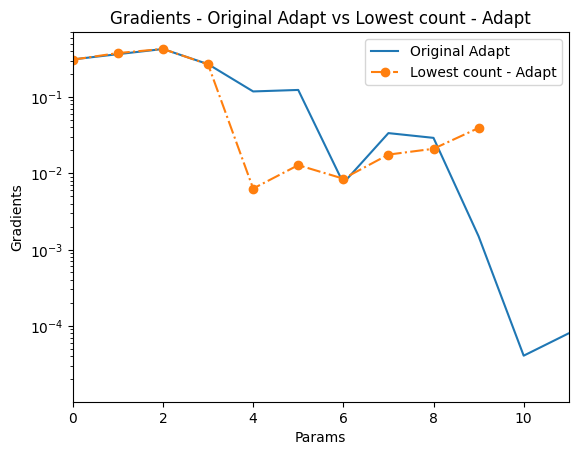

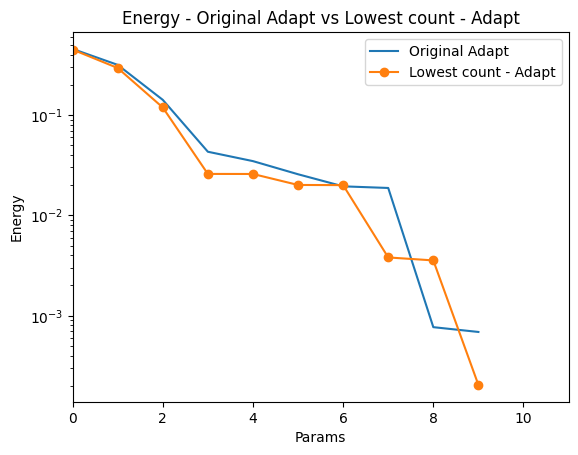

In [7]:
import numpy as np
grad = np.array(grad)

G_Exact = (0.3100451588582116 , 0.36333417728273754, 0.4247574417703076, 0.2689421354231678, 0.11800197933700611, 0.12345368822802208,
            0.007420281812857612, 0.03354563739855884 , 0.029061752158627868, 0.0014907673809587962, 4.058027986704677e-05, 7.976896690634755e-05,
            5.913441683514514e-05, 0.00011328401551519846, 1.989246929409716e-05, 3.843530082175278e-05,  0.0017755760879906296, 0.0009282356568736209,
             2.0769533991756538e-05, 2.0776790979757515e-05,1.678514206528755e-05)

E_Exact = np.array([-1.430083652442, -1.569460375668, -1.743633446894,-1.842110157560,
                     -1.850435938949, -1.859460023915,  -1.865676740601, -1.866387973815, 
                       -1.884356032844,-1.884436165205 ])

Error_OAdapt = np.array(E_Exact - FCI)
Error_NAdapt = np.array(energies - FCI)

GP = np.arange(0,21, 1.0)
Grad_distance = np.arange(0, 10, 1.0)

import matplotlib.pyplot as plt
plt.plot(GP, G_Exact, '-', label = 'Original Adapt')
plt.plot(Grad_distance, grad, '-.o', label = 'Lowest count - Adapt')
plt.legend()
plt.yscale('log')
plt.xlim(0,11)
plt.xlabel ('Params')
plt.ylabel('Gradients')
plt.title('Gradients - Original Adapt vs Lowest count - Adapt')
plt.show()


plt.plot(Grad_distance, Error_OAdapt, '-', label = 'Original Adapt') 
plt.plot(Grad_distance, Error_NAdapt, '-o', label = 'Lowest count - Adapt') 
plt.legend()
plt.xlim(0,11)
plt.xlabel ('Params')
plt.ylabel('Energy')
plt.yscale('log')
plt.title('Energy - Original Adapt vs Lowest count - Adapt')
plt.show()